In [122]:
# Importing Libraries
import pandas as pd
import numpy as np

import nltk

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer

from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation
from gensim.parsing.porter import PorterStemmer

from gensim.models import Word2Vec

from sklearn.cluster import MiniBatchKMeans, KMeans

from sklearn.manifold import TSNE

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics

ModuleNotFoundError: No module named 'wordcloud'

In [145]:
def most_freq_words(n_gram, corpus, labels, n_cluster, num_words):
    dict_cluster = {'sentences': corpus, 'cluster': labels}
    data_cluster = pd.DataFrame(data=dict_cluster)

    m_words = []
    n = []

    for i in range(n_cluster):
        cl = data_cluster.loc[data_cluster['cluster'] == i]
        cl = np.array(cl['sentences'])
        cl_count = CountVectorizer(ngram_range=(n_gram, n_gram), token_pattern=r'\b\w+\b', 
                                   analyzer= 'word', max_features=num_words)
        cl_count.fit_transform(cl)
        words = [key for key in cl_count.vocabulary_]
        m_words.append(words)
        n.append(i)
    dict_most_freq = {'cluster':n, 'most frequent words':m_words}
    return pd.DataFrame(data=dict_most_freq)

In [2]:
# Separating per years in list
def sep_years(data, initial_year=2003, final_year=2017):
    years = np.arange(initial_year,final_year)
    data_years = []

    for year in years:
        data_years.append(data[data['publish_date']//10000 == year])
    return data_years

In [3]:
# Process raw text (remove stop words, remove punctuation and get root of words)
def process_text(data):
    p = PorterStemmer()
    data = [p.stem_sentence(strip_punctuation(remove_stopwords(sentence))) for sentence in data]
    return data

In [4]:
# Reading Data
data = pd.read_csv('data/news_headlines.csv')

In [5]:
# Showing head of data frame
data.head()

,publish_date,headline_text
0,20030303,unhooked brakes to blame for taiwan train disa...
1,20030918,oldest prisoner in tas released citing health
2,20030913,nine reportedly dead in portuguese plane crash
3,20031031,nurses welcome medicare rebate plan
4,20030930,un cuts its iraq staff


In [6]:
# Dropping duplicated -> headline_text

data = data.drop_duplicates(['headline_text'])

In [7]:
corpus = data['headline_text']

corpus = process_text(corpus)

In [8]:
t = 0
while '' in corpus:
    t += 1
    corpus.remove('')

print(t)

19


In [9]:
# N-Gram Feature Extractor

d_max = .3
d_min = 1

vect_2gram = TfidfVectorizer(ngram_range=(2, 2), token_pattern=r'\b\w+\b',
                             max_df=d_max, min_df=d_min, analyzer= 'word', max_features=1000)
vect_3gram = TfidfVectorizer(ngram_range=(3, 3), token_pattern=r'\b\w+\b',
                             max_df=d_max, min_df=d_min, analyzer= 'word', max_features=1000)
vect_4cgram = TfidfVectorizer(ngram_range=(4, 4), token_pattern=r'\b\w+\b',
                              max_df=d_max, min_df=d_min, analyzer= 'char', max_features=1000)

X_2 = vect_2gram.fit_transform(corpus)
X_3 = vect_3gram.fit_transform(corpus)
X_4 = vect_4cgram.fit_transform(corpus)

X_2_analyze = vect_2gram.build_analyzer()
X_3_analyze = vect_3gram.build_analyzer()
X_4_analyze = vect_4cgram.build_analyzer()

print('2gram', X_2_analyze('Bi-grams are cool!'))
print('3gram', X_3_analyze('Bi-grams are cool!'))
print('4cgram', X_4_analyze('Bi-grams are cool!'))

print(np.shape(X_2))
print(np.shape(X_3))
print(np.shape(X_4))

2gram ['bi grams', 'grams are', 'are cool']
3gram ['bi grams are', 'grams are cool']
4cgram ['bi-g', 'i-gr', '-gra', 'gram', 'rams', 'ams ', 'ms a', 's ar', ' are', 'are ', 're c', 'e co', ' coo', 'cool', 'ool!']
(643696, 1000)
(643696, 1000)
(643696, 1000)


In [9]:
corpus_token = [[word for word in corpu.split()] for corpu in corpus]

model = Word2Vec(corpus_token, min_count=1, size = 200)

In [10]:
X = []
X_sentence = []

i = 0                
                
for sentence_token in corpus_token:
    print(i, end ='\r')
    i += 1
    for token in sentence_token:
        X_sentence.append(model.wv[token])
    feat_mean = np.average(X_sentence, axis=0)
    X.append(feat_mean/np.max(feat_mean))
    X_sentence = []

print(np.shape(X))

(643696, 200)


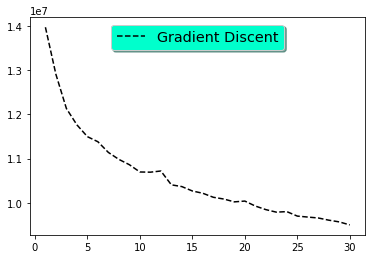

In [11]:
n_clusters = 30
lst_clust = []
cost_function = []


#reduced_data = TruncatedSVD(n_components=100).fit_transform(X_4)
#print(np.shape(reduced_data))

#reduced_data = Normalizer(copy=False).fit_transform(reduced_data)


for i in range(1, n_clusters+1):
    print(i ,end='\r')
    km = MiniBatchKMeans(n_clusters=i, init='k-means++',n_init=1, max_iter=100)
    km.fit(X)
    lst_clust.append(i)
    cost_function.append(km.inertia_)

# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(lst_clust, cost_function, 'k--', label='Gradient Discent')

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('#00FFCC')

plt.show()

In [22]:
km = MiniBatchKMeans(n_clusters=8, init='k-means++',n_init=1, max_iter=100)
km.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=8,
        n_init=1, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [149]:
dict_cluster = {'sentences': corpus, 'cluster': km.labels_}
data_cluster = pd.DataFrame(data=dict_cluster)

cl = data_cluster.loc[data_cluster['cluster'] == 0]

cl = np.array(cl['sentences'])

print(np.shape(cl))

cl_count = CountVectorizer(ngram_range=(1, 1), token_pattern=r'\b\w+\b', analyzer= 'word', max_features=20)

document = cl_count.fit_transform(cl)

print(cl_count.vocabulary_)

for key in cl_count.vocabulary_:
    print(key)
    
a = [key for key in cl_count.vocabulary_]
print(a)  

print(most_freq_words(n_gram=1,corpus=corpus,labels=km.labels_,n_cluster=8, num_words=10))


(57578,)
{'woman': 19, 'jail': 12, 'case': 4, 'trial': 18, 'accus': 0, 'court': 7, 'assault': 3, 'sentenc': 16, 'face': 10, 'murder': 14, 'charg': 5, 'man': 13, 'drug': 9, 'guilti': 11, 'appeal': 2, 'death': 8, 'polic': 15, 'child': 6, 'alleg': 1, 'sex': 17}
woman
jail
case
trial
accus
court
assault
sentenc
face
murder
charg
man
drug
guilti
appeal
death
polic
child
alleg
sex
['woman', 'jail', 'case', 'trial', 'accus', 'court', 'assault', 'sentenc', 'face', 'murder', 'charg', 'man', 'drug', 'guilti', 'appeal', 'death', 'polic', 'child', 'alleg', 'sex']
   cluster                                most frequent words
0        0  [jail, trial, accus, court, face, murder, char...
1        1  [water, boost, council, fund, resid, new, nsw,...
2        2  [health, plan, sai, minist, govt, urg, mp, new...
3        3  [dead, crash, man, car, polic, kill, attack, m...
4        4  [new, school, home, year, dai, australia, coun...
5        5  [coach, cup, final, england, tiger, injuri, wi...
6       

In [33]:
# Tests
print(km.predict(X_2[:50,:]))
print(data[:20])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 9 1 1 1 1 1 1 4 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
    publish_date                                      headline_text
0       20030303  unhooked brakes to blame for taiwan train disa...
1       20030918      oldest prisoner in tas released citing health
2       20030913     nine reportedly dead in portuguese plane crash
3       20031031                nurses welcome medicare rebate plan
4       20030930                             un cuts its iraq staff
5       20030601      tougher water restrictions loom after dry may
6       20030715     illegal fishing review to hold public meetings
7       20030723          minardi sign italian bruni as test driver
8       20030910                       man breaks leg in cliff fall
9       20031125                  bush signs off on troops pay rise
10      20030530       cwealth not responsible for regional airport
11      20031114      indonesia knew about melville boat tow howard
12      20031